## **Imports**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time
import threading
import pandas as pd

from tabulate import tabulate
from IPython.display import display, HTML,clear_output
from tqdm import tqdm
from scipy import stats

import sys
sys.path.append("F:\Austin\helpers")
from helpers.experiment_v3 import *
#from openfiles import *

# Initialize instruments
instruments = init_instruments(printing=False, force_reconnect=True)

# Create local instrument variables
yoko_rch  = instruments['yoko_rch']    # Right Channel (R-ch electrode)
yoko_lgd  = instruments['yoko_lgd']    # Left Guard (L-ch M-res gate)
yoko_rgt  = instruments['yoko_rgt']    # Right Gate (R-ch R-res gate)
yoko_mgt  = instruments['yoko_mgt']    # Left Gate (R-ch M-res gate)
yoko_pin  = instruments['yoko_pin']    # Pinch Gate (Pinch gate)
yoko_res  = instruments['yoko_res']    # Reservoir Bias (M&R-res bias)
lockin_LF = instruments['lockin_LF']
lockin_HF = instruments['lockin_HF']
gen_sign  = instruments['gen_sign']
gen_fila  = instruments['gen_fila']
vna13     = instruments['vna13']
vna20     = instruments['vna20']
dpg       = instruments['dpg']
daq       = instruments['daq']

# Unused/Implemented Devices 
#bnc         = BNC845()
#gen_high    = HP8648B("GPIB::20::INSTR")
#sigcore     = SignalCore(name="SignalCore", address="10003410")

# Select attached VNA (if any)
if vna13 is not None and hasattr(vna13, 'address'):
    vna = vna13
elif vna20 is not None and hasattr(vna20, 'address'):
    vna = vna20
else:
    vna = None
    print("No VNA is connected.")

Instrument,Connected,Address
VNA 120,✘,None
VNA 220,✔,GPIB0::3::INSTR
SR830,✔,GPIB0::10::INSTR
SR844,✔,GPIB0::11::INSTR
DPG202,✔,COM4
MCC DAQ,✔,USB Box
BlueFors,✔,USB Direct
Yoko (rch),✔,GPIB0::7::INSTR
Yoko (lgd),✔,GPIB0::1::INSTR
Yoko (rgt),✔,GPIB0::21::INSTR


## **Dictionaries**

In [ ]:
# Dictionary for easy access to instruments
instrument_registry = {
     'yoko_rch': yoko_rch,
     'yoko_lgd': yoko_lgd,
     'yoko_rgt': yoko_rgt,
     'yoko_mgt': yoko_mgt,
     'yoko_pin': yoko_pin,
     'yoko_res': yoko_res,
     'gen_sign': gen_sign,
     'gen_fila': gen_fila,
          'daq': daq,
          'vna': vna,
    'lockin_LF': lockin_LF,
    'lockin_HF': lockin_HF,
     'bluefors': bluefors,
}

# Dictionaries for control of instrument functions
control_instr_dict = {
        # Sweepable Parameters
                'Vrch': [ 0.8,  yoko_rch, 'source_voltage',   'ramp_to_voltage',   'V'],
                'Vrgt': [ 0.8,  yoko_rgt, 'source_voltage',   'ramp_to_voltage',   'V'],
                'Vmgt': [ 0.8,  yoko_mgt, 'source_voltage',   'ramp_to_voltage',   'V'],
               'Vsign': [0.10,  gen_sign,      'amplitude', 'ramp_to_amplitude','Vrms'],
               'Fsign': [0.2e6, gen_sign,      'frequency', 'ramp_to_frequency',  'Hz'],
        # Constant Parameters
                'Vlgd': [-0.4,  yoko_lgd, 'source_voltage',   'ramp_to_voltage',   'V'],
                'Vpin': [-0.1,  yoko_pin, 'source_voltage',   'ramp_to_voltage',   'V'],
                'Vres': [ 1.0,  yoko_res, 'source_voltage',   'ramp_to_voltage',   'V'],
               'Vfila': [ 3.0,  gen_fila,      'amplitude', 'ramp_to_amplitude', 'Vpp'],
               'Ffila': [   1,  gen_fila,      'frequency', 'ramp_to_frequency',  'Hz'],
#             'hf_pow': [    -25,   sc,         'set_power',    'ramp_to_power',  'dB'],
#            'hf_freq': [4.0*GHz,   sc,     'set_frequency','ramp_to_frequency',  'Hz'],
#            'sa_freq': [  4*GHz,  sad,'set_freq_for_power','ramp_to_frequency',  'Hz']
}

# Dictionaries for control and readout of the VNA
vna_control_dict = {
        # Sweepable Parameters
          'freq_range': [      (3.00e9, 6.00e9), vna,  'set_frequency_range',  'Hz'],
               'power': [                   -30, vna,            'set_power', 'dBm'],
          'elec_delay': [                 10e-9, vna, 'set_electrical_delay',   's'],
        # Constant Parameters 
        'set_vna_meas': [    ('meas', 'S21', 1), vna,      'set_measure_def',    ''],
              'format': [                'MLOG', vna,           'set_format',    ''], 
           'sweep_pts': [                 10001, vna,     'set_sweep_points', 'pts'],  
             'num_avg': [                     1, vna,         'set_averages','avgs'],
              'set_bw': [                   1e3, vna,             'set_ifbw',  'Hz'],
}

# Dictionaries for readout of instrument values
readout_instr_dict = {
                'Vlfx': [lockin_LF,            'x',  'V'],
                'Vlfy': [lockin_LF,            'y',  'V'],
                'Vhfx': [lockin_HF,            'x',  'V'],
                'Vhfy': [lockin_HF,            'y',  'V'],
            'vna_meas': [      vna,  'read_data_y', 'dB'],
            'vna_freq': [      vna,  'get_fpoints', 'Hz'],
            'daq_meas': [      daq,         'scan',   '']
}

# Dictionaries for readout of BlueFors values
readout_bluefors_dict = {
               'T_50K': [ bluefors,      lambda bf: bf.get_temperature(1), 'K'],
                'T_4K': [ bluefors,      lambda bf: bf.get_temperature(2), 'K'],
             'T_Still': [ bluefors,      lambda bf: bf.get_temperature(5), 'K'],
               'T_MXC': [ bluefors,      lambda bf: bf.get_temperature(6), 'K'],
             'H_still': [ bluefors,      lambda bf: bf.get_heater('a2_u'), 'W'],
           'H_MXC_per': [ bluefors,       lambda bf: bf.get_heater('htr'), '%'],
           'H_MXC_rng': [ bluefors, lambda bf: bf.get_heater('htr_range'), 'W']
}

# Create a new experiment instance where the dictionaries are applied
expr = exp3(control_instr_dict, 
              vna_control_dict, 
            readout_instr_dict, 
         readout_bluefors_dict,
           instrument_registry)

# Constants for frequency conversions
GHz = 1e9
MHz = 1e6
kHz = 1e3

# Function to get the temperatures from the BlueFors fridge
def get_temps():
    temp_data = {}
    for label, (device, func, units) in readout_bluefors_dict.items():
        val = np.around(func(device), 2)
        temp_data[label] = val
        print(f"{label}: {val} {units}")
    return temp_data

# VNA measurement configuration
expr.set_vna_meas = ('TEST_2', 'S21', 1)
form_tag = 'SDATA'

Attributes    Values
------------  ------------------
Vrch          800 mV
Vrgt          800 mV
Vmgt          800 mV
Vsign         0.1 Vrms
Fsign         200 kHz
Vlgd          -400 mV
Vpin          -100 mV
Vres          1 V
Vfila         3 Vpp
Ffila         1 Hz
freq_range    (3, 6) GHz
power         -30 dBm
elec_delay    10 ns
set_vna_meas  ('meas', 'S21', 1)
format        MLOG
sweep_pts     1e+04 pts
num_avg       1 avgs
set_bw        1 kHz
T_50K         47.4 K
T_4K          3.44 K
T_Still       1.1 K
T_MXC         506 mK
H_still       0 W
H_MXC_per     53 %
H_MXC_rng     6 W


## **Experiment Implementation**

Here is where the values for the specific experiment can be entered.  Default values for when this notebook is initialized are set in the dictionaries above.  However, when these values are changed anywhere else in the notebook, they will remain at that changed value until changed again or the notebook is restarted.  Values do not return to the dictionary defaults on their own.

In [3]:
# Transport signal generator
gen_out = 'on'
gen_sign.output = gen_out

expr.set_vna_meas = ('TEST_2', 'S21', 1)
form_tag = 'SDATA'
expr.format = form_tag
expr.power =  10
expr.set_bw = 400
expr.sweep_pts = 1201
expr.elec_delay = 54.0e-9
expr.freq_range = (5.35*GHz, 5.55*GHz) 
expr.num_avg = 10
expr.comment1 = f'60 dB extra attn, ZX60 Amps (1) on output'
#expr.comment2 = f'with helium'

expr.table()

Attributes    Values
------------  -----------------------------------------
Vrch          800 mV
Vrgt          -200 mV
Vmgt          -200 mV
Vsign         0.1 Vrms
Fsign         3.4 MHz
Vlgd          -200 mV
Vpin          -300 mV
Vres          1 V
Vfila         3 Vpp
Ffila         1 Hz
freq_range    (5.35, 5.55) GHz
power         10 dBm
elec_delay    54 ns
set_vna_meas  ('TEST_2', 'S21', 1)
format        SDATA
sweep_pts     1.2e+03 pts
num_avg       10 avgs
set_bw        400 Hz
T_50K         47 K
T_4K          3.43 K
T_Still       1.1 K
T_MXC         508 mK
H_still       0 W
H_MXC_per     53 %
H_MXC_rng     6 W
comment1      60 dB extra attn, ZX60 Amps (1) on output


In [4]:
expr.sweep_params(
    var     =   ['power'],
    s1      =   10, 
    s2      =  -30,   
    num     =   9,
    scale   =   'linear',
    offset  =   [0]
)

expr.step_params(
    var     =   [],
    s1      =   0.001, 
    s2      =   0.002,   
    
    num     =   3,
    scale   =   'linear',
    offset  =   [0]
)

# Set the experiment name
exp_name = 'Resonator_Power_577mK'

# Initialize the VNA for 1D VNA measurements
expr.init_reads(printing=False, format_router=form_tag);

# Run the VNA experiment
expr.run_experiment(exp_name, savedata=True, format_tag=form_tag); #, hold_time={'Vsign':3.0});

Sweeping power:   0%|          | 0/9 [00:00<?, ?it/s]

Non-index columns: ['freq_range', 'power', 'vna_real', 'vna_imag', 'vna_freq [Hz]']
Data saved to database


In [83]:
expr.Vsign = 0.2

## **Electron Firing**

In [ ]:
# --- General Parameters for Filament Firing ---

# Filament generator direct signal shaping
gen_fila.output           = 'off'
gen_fila.shape            = 'SQU'
gen_fila.square_dutycycle = 50
gen_fila.polarity         = 'INV'
gen_fila.burst_mode       = 'TRIG'
gen_fila.burst_ncycles    = 1
gen_fila.burst_state      = True
gen_fila.trigger_source   = 'BUS'
gen_fila.trigger_delay    = 0.5
gen_fila.output_polarity  = 'INV'

# daq filament readout setup
daq.voltage_range         = 0
daq.status                = True

# VNA configuration
expr.freq_range = (5.32*GHz, 5.52*GHz)
vna.set_ifbw(200)
vna.set_measure_def('meas', 'S21', 1)
vna.set_averages(1)
vna.set_average_state(True)

# Initialize DataSaver
datasaver = DataSaver()

### Single Filament Firing

In [ ]:
# --- Specific Parameters for Single Filament Firing ---

# Experiment name
experiment_name = "VNA_SingleFire"

# --- Define relevant constants ---
Vfil  = 3.0      # Filament voltage in Vpp (1.8 Vpp minimum to turn on)
Ffil  = 2.0      # Filament frequency in Hz
Vsig  = 0.100    # Transport signal amplitude in Vrms
Fsig  = 0.2      # Transport signal frequency in MHz
Vrez  = 1.0      # Reservoir voltage in V
Mtime = 3.0      # Measurement time in s
Mrate = 2000     # Measurement rate in S/s

VNAon  = True    # VNA output state
VNApts = 501     # VNA points
VNApow = 10      # VNA power in dBm


expr.Vfila           = Vfil
gen_fila.offset      = -Vfil/2
expr.Fsign           = Fsig*MHz
expr.Vsign           = Vsig
expr.Ffila           = Ffil
expr.Vres            = Vrez
daq.measurement_time = Mtime
daq.sampling_rate    = Mrate

vna.set_power(VNApow)
vna.set_sweep_points(VNApts)
vna.set_output('ON' if VNAon else 'OFF')

# Deposition preparation
expr.deposition_prep(Vres=1.2, Vpn=-0.1, Vac=0.1) # Vgt=-0.4

In [ ]:
# --- Single Filament Firing with VNA Logging ---

logger = VNALogger(vna, dpg, datasaver,
                   exp_name=experiment_name,
                   columns=["ElapsedSeconds", "TimestampStr", 
                            "Pressure1", "Pressure2",
                            "Frequency", "VNA Real", "VNA Imag"],
                   overwrite=False)

threading.Thread(target=logger.vna_log,
                 kwargs={      'wait_time': 0,
                         'record_pressure': True},
                 daemon=True).start()

time.sleep(10)

times, data = expr.deposit_electrons()

Recording started...
filament turned on
scan started
Scan completed successfully.
Data copied from buffer - complete.
filament turned off


Final save...
Data saved to data\2026-02-03\2026-02-03_VNA_PostFire.db
Recording stopped.


### Single Filament Plotting

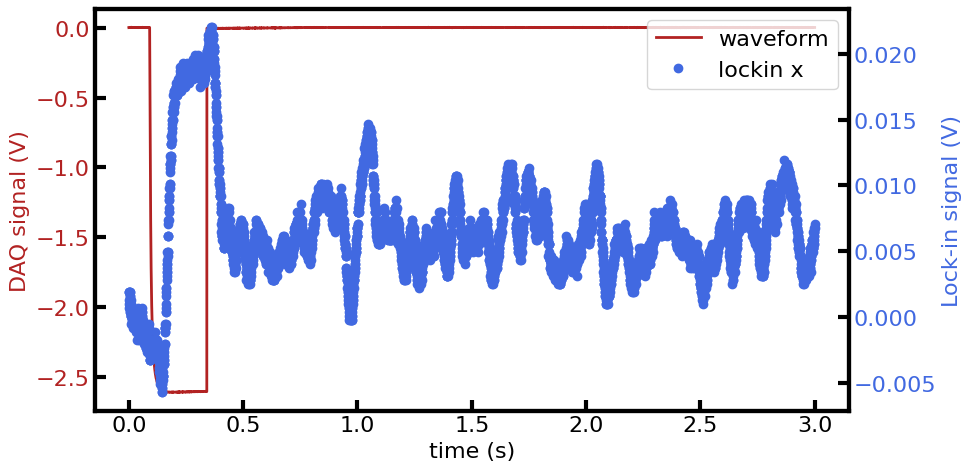

In [67]:
plt.rcParams.update({'font.size': 16})
fig, ax1 = plt.subplots(figsize=(10, 5))

# First y-axis: waveform
ax1.plot(times, data[:,0], color='firebrick', label='waveform', lw=2)
ax1.set_xlabel('time (s)')
ax1.set_ylabel('DAQ signal (V)', color='firebrick')
ax1.tick_params(axis='x', labelcolor='black', width=3, length=8, direction='in')
ax1.tick_params(axis='y', labelcolor='firebrick', width=3, length=8, direction='in')
#ax1.set_xlim(0.00,0.25)
#ax1.set_ylim(-0.32,-0.29)

# Second y-axis: lockin signal
ax2 = ax1.twinx()
lockin_signal = 1 * (data[:,1] - np.average(data[:100,1]))
ax2.plot(times, lockin_signal,'o', color='royalblue', label='lockin x', lw=2)
ax2.set_ylabel('Lock-in signal (V)', color='royalblue')

# Ensure (-0.1, 0.1) is included
ymin = min(np.min(data[1:,1]), -0.1)
ymax = max(np.max(data[1:,1]),  0.1)
# Apply the limits
#ax2.set_ylim(ymin, ymax)

ax2.tick_params(axis='y', labelcolor='royalblue', width=3, length=8, direction='in')

# Thicken the border (spines)
for spine in ax1.spines.values():
    spine.set_linewidth(3)
for spine in ax2.spines.values():
    spine.set_linewidth(3)

# Add legends manually
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

plt.tight_layout()
plt.show()


### Transport Sweep

In [ ]:
expr.Vsign = 0.200
form_tag = 'SDATA'
gen_sign.output = 'on'

expr.sweep_params(
    var     =   ['Vrch', 'Vmgt', 'Vrgt'],
    s1      =   0.2, 
    s2      =   1.0,   
    num     =   181,
    scale   =   'linear',
    offset  =   [0, 0, 0]
)

expr.step_params(
    var     =   [],
    s1      =   0, 
    s2      =   0,   
    num     =   1,
    scale   =   'linear',
    offset  =   [0]
)

# Set the experiment name
exp_name = 'Transport'

# Initialize the VNA for 1D VNA measurements
expr.init_reads(printing=False, format_router=form_tag);

# Run the VNA experiment
sweep, step, values = expr.run_experiment(exp_name, savedata=True, 
                            format_tag=form_tag, return_data=True);

Non-index columns: ['Vrch', 'Vmgt', 'Vrgt', 'Vhfx', 'Vhfy']
Avoiding overwrite, new filename: 2026-02-03_Transport-25.db
Data saved to database


### VNA and Microchannel Sweep

In [ ]:
expr.power = 10

expr.Vsign = 0.200
expr.set_vna_meas = ('TEST_2', 'S21', 1)
form_tag = 'SDATA'

expr.sweep_params(
    var     =   ['freq_range'],
    s1      =   5.35*GHz, 
    s2      =   5.50*GHz,   
    num     =   2001,
    scale   =   'linear',
    offset  =   [0]
)

expr.step_params(
    var     =   ['Vrch', 'Vmgt', 'Vrgt'],
    s1      =   0.7, 
    s2      =   0.95,   
    num     =   251, #181
    scale   =   'linear',
    offset  =   [0, 0, 0]
)

# Set the experiment name
exp_name = 'Transport'

# Initialize the VNA for 1D VNA measurements
expr.init_reads(printing=False, format_router=form_tag);

# Run the VNA experiment
sweep, step, values = expr.run_experiment(exp_name, savedata=True, 
                            format_tag=form_tag, return_data=True);

Stepping ['Vrch', 'Vmgt', 'Vrgt']:   0%|          | 0/251 [00:00<?, ?it/s]

Stepping ['Vrch', 'Vmgt', 'Vrgt']: 100%|██████████| 251/251 [18:06<00:00,  4.33s/it]


Non-index columns: ['Vrch', 'Vmgt', 'Vrgt', 'freq_range', 'vna_real', 'vna_imag', 'vna_freq [Hz]']
Avoiding overwrite, new filename: 2026-02-03_Transport-24.db
Data saved to database


In [19]:
vna.set_trigger_continuous(True)

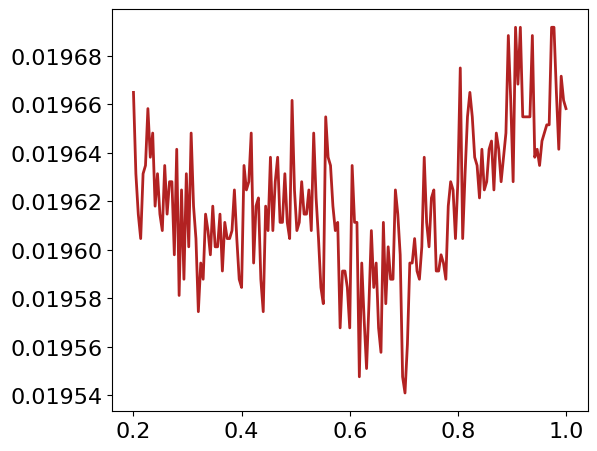

In [21]:
plt.rcParams.update({'font.size': 16})
values = np.array(values)

V = values[:,0]
x = values[:,3]
y = values[:,4]
r = np.sqrt(x**2 + y**2)

# First y-axis: waveform
plt.plot(V, x, color='firebrick', lw=2)


plt.tight_layout()
plt.show()

In [92]:
np.shape(values)

(1001, 6)

TypeError: Incompatible X, Y inputs to pcolormesh; see help(pcolormesh)

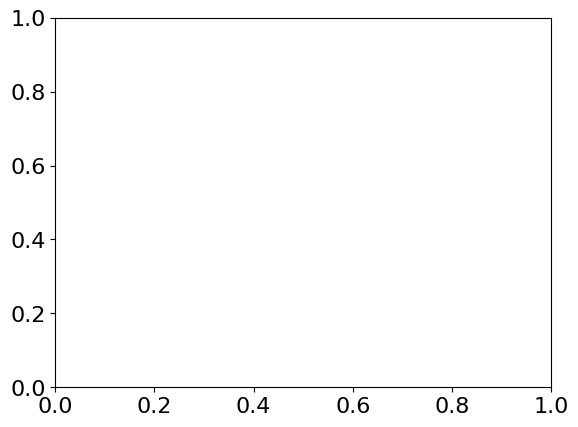

In [83]:
plt.pcolormesh(sweep, step, values, cmap='viridis')

In [ ]:
# --- General Parameters for Filament Firing ---

# Filament generator direct signal shaping
gen_fila.output           = 'off'
gen_fila.shape            = 'SQU'
gen_fila.square_dutycycle = 50
gen_fila.polarity         = 'INV'
gen_fila.burst_mode       = 'TRIG'
gen_fila.burst_ncycles    = 1
gen_fila.burst_state      = True
gen_fila.trigger_source   = 'BUS'
gen_fila.trigger_delay    = 0.5
gen_fila.output_polarity  = 'INV'

# daq filament readout setup
daq.voltage_range         = 0
daq.status                = True

# VNA configuration
expr.freq_range = (5.32*GHz, 5.52*GHz)
vna.set_ifbw(200)
vna.set_measure_def('meas', 'S21', 1)
vna.set_averages(1)
vna.set_average_state(True)

# Initialize DataSaver
datasaver = DataSaver()

### Looped Electron Firing

In [ ]:
# --- Experiment name ---
exp_name = "Filament_amp_vres"


# --- Define relevant constants ---
Vfil  = 3.0      # Filament voltage in Vpp (1.8 Vpp minimum to turn on)
Ffil  = 2.0      # Filament frequency in Hz
Vsig  = 0.100    # Transport signal amplitude in Vrms
Fsig  = 0.2      # Transport signal frequency in MHz
Vrez  = 1.0      # Reservoir voltage in V
Mtime = 3.0      # Measurement time in s
Mrate = 2000     # Measurement rate in S/s

VNAon  = True    # VNA output state
VNApts = 501     # VNA points
VNApow = 10      # VNA power in dBm

expr.Vfila           = Vfil
gen_fila.offset      = -Vfil/2
expr.Fsign           = Fsig*MHz
expr.Vsign           = Vsig
expr.Ffila           = Ffil
expr.Vres            = Vrez
daq.measurement_time = Mtime
daq.sampling_rate    = Mrate

vna.set_power(VNApow)
vna.set_sweep_points(VNApts)
vna.set_output('ON' if VNAon else 'OFF')


# --- Deposition preparation ---
expr.deposition_prep(Vres=1.2, Vpn=-0.1, Vac=0.1) # Vgt=-0.4


# --- Define sweep axes ---
amp_values = np.linspace(2.7, 3.5, 41)
# frq_values = [1.0, 2.0, 4.0]
res_values = [0.8, 1.0, 1.2]
sweep_axes = {"amp": amp_values, "res": res_values}


# --- Define the setters for only the parameters you want to sweep ---
setters = {
    "amp": lambda v: (setattr(expr, "Vfila", float(v)),
                      setattr(gen_fila, "offset", -float(v)/2.0)),
    "res": lambda v: setattr(expr, "Vres", float(v))
}


# --- Define a prep_fn that accepts the current point context dict ---
prep_fn = lambda ctx: expr.deposition_prep(
    Vres=ctx.get("Vres", 1.0),          # Vres default 1.0 V
    Vpn=-0.1,
    Vac=0.1
)


# --- Run the sweep ---
filepath, axes_order, axes_values, t, cubes = expr.deposition_sweep(
    experiment_name=exp_name,
    sweep_axes=sweep_axes,
    setters=setters,
    datasaver=datasaver,                # external DataSaver instance
    daq=daq,                            # DAQ handle (if not on self)
    trigger_fn=expr.deposit_electrons,  # fire electrons
    prep_fn= prep_fn,                   # reset electron system
    settle_s= 240,
    overwrite=False,
    extra_metadata={
        "Filament Voltage Vpp": Vfil,
        "Filament Frequency Hz": Ffil,
        "Transport Voltage Vrms": Vsig,
        "Transport Frequency Hz": Fsig*MHz,
        "Reservoir Voltage V": Vrez,
        "Measurement Time s": Mtime,
        "Measurement Rate S/s": Mrate,
        #"VNA Power dBm": 10,
        #"VNA ifbw Hz": 200,
        #"VNA Points": 501,
        #"VNA Frequency GHz": (f_vna_min/GHz, f_vna_max/GHz)
    },
    verbose=False,                      # use only the progress bar
    quiet_trigger=True,                 # silence deposit_electrons prints
    default_Vres=1.0,

)


# --- Cleanup ---
vna.set_output('OFF')
gen_fila.output = 'off'


# --- Output summary ---
print("Saved:", filepath)
print("Axes:", axes_order)
print("Time samples:", len(t))


# If two axes were swept, cubes are available
if cubes is not None:
    p1, p2, time_axis, Z1, Z2 = cubes
    print("Z1 shape (amp x frq x time):", Z1.shape)
    print("Z2 shape (amp x frq x time):", Z2.shape)

Filament_amp_vres:   0%|          | 0/123 [00:00<?, ?pt/s]

Filament_amp_vres: 100%|██████████| 123/123 [8:41:20<00:00, 254.31s/pt]  


Data saved to data\2026-02-03\2026-02-03_Filament_amp_vres.db
Saved: data\2026-02-03\2026-02-03_Filament_amp_vres.db
Axes: ['amp', 'res']
Time samples: 6000
Z1 shape (amp x frq x time): (41, 3, 6000)
Z2 shape (amp x frq x time): (41, 3, 6000)


### Looped Electron Firing Plots

NameError: name 'time_axis' is not defined

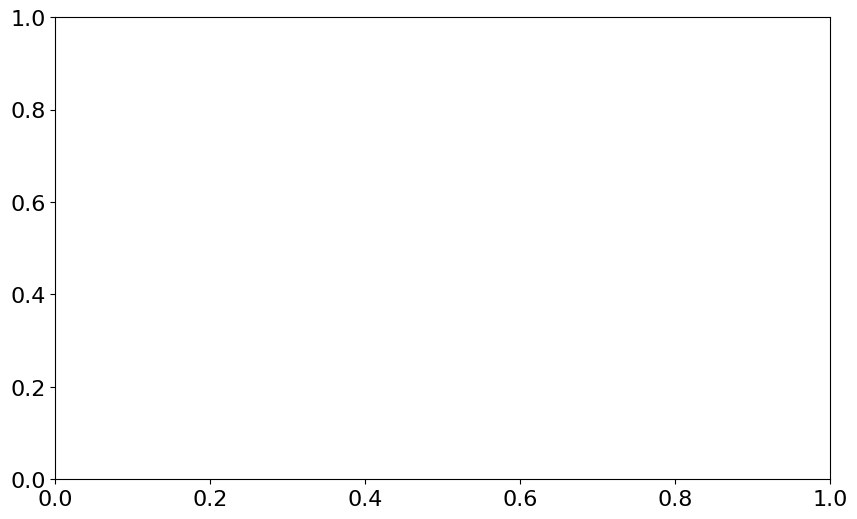

In [22]:
fig, ax1 = plt.subplots(figsize=(10, 6))

cmp = ax1.pcolormesh(time_axis, amp_values, Z2[:,2,:], shading='nearest')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel(r'Filament Amplitude ($V_{\text{pp}}$)')

ax1.tick_params(axis='both', width=3, length=8, direction='in', pad=10)
ax1.set_ylim(amp_values[0], amp_values[-1])
ax1.set_yticks(amp_values[::5])

cbar = plt.colorbar(cmp, ax=ax1)
cbar.set_label('Lock-in Signal (V)', labelpad=15)
cbar.ax.tick_params(width=3, length=8, direction='out')

for spine in ax1.spines.values():
    spine.set_linewidth(3)
for spines in cbar.ax.spines.values():
    spines.set_linewidth(3)
    

3.0


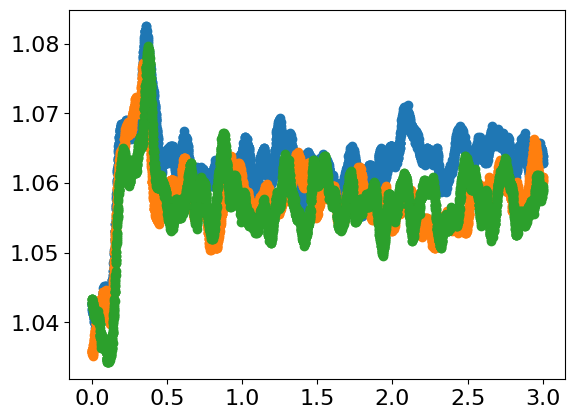

In [63]:
plt.plot(time_axis, Z2[15,0,:],'o-')
plt.plot(time_axis, Z2[15,1,:],'o-')
plt.plot(time_axis, Z2[15,2,:],'o-')
print(amp_values[15])

## **Oscilloscope Collection**

I mistakenly did not save this when I originally created it, so this code likely does not work correctly but is still close to what worked.

In [12]:
from newinstruments import Tektronix_7054 as oscope

scope = oscope.TektronixDPO7054('GPIB0::4::INSTR')
scope.set_channel('CH3')
scope.set_acq_mode('SAMPLE')
time, data = scope.read_waveform()

Connected to: TEKTRONIX,DPO7054,B022167,CF:91.1CT FV:4.0.1 Build 16


In [13]:
# Fixed filament generator settings
gen_fila.output           = 'off'
gen_fila.shape            = 'SQU'
gen_fila.frequency        = 1  #1
gen_fila.square_dutycycle = 5  #5
gen_fila.polarity         = 'INV'
gen_fila.burst_state      = False

# Filament voltages
amps = np.linspace(1.0, 3.0, 5) #41

data_matrix = []
columns = ['Sourced [V]', 'Time [s]', 'Filament [V]', 'Electrode [V]']

gen_fila.output = 'on'

for amp in amps:
    # Filament generator setup
    gen_fila.amplitude = amp
    gen_fila.offset = -amp / 2
    sleep(3)

    # Read scope data for CH2 and CH3
    waveforms = scope.read_multiple_channels(['CH2', 'CH3'])
    assert 'CH2' in waveforms and 'CH3' in waveforms, "Scope result missing CH2 or CH3"

    time_ch2, vals_ch2 = waveforms['CH2']
    time_ch3, vals_ch3 = waveforms['CH3']

    # Sanity alignment: they should match; if not, trim to common length
    n = min(len(time_ch2), len(vals_ch2), len(time_ch3), len(vals_ch3))
    time_ch2 = time_ch2[:n]
    vals_ch2 = vals_ch2[:n]
    vals_ch3 = vals_ch3[:n]

    # If time arrays differ slightly, you can choose one as reference (usually identical)
    # or resample; most Tek configs return identical XINCR & length per channel.
    time_ref = time_ch2

    for t, v2, v3 in zip(time_ref, vals_ch2, vals_ch3):
        data_matrix.append((round(amp, 3), t, v2, v3))

# Turn off filament generator
gen_fila.output = 'off'


In [ ]:
# Fixed filament generator settings
gen_fila.output           = 'off'
gen_fila.shape            = 'SQU'
gen_fila.frequency        = 1   #1
gen_fila.square_dutycycle = 15  #5
gen_fila.polarity         = 'INV'
gen_fila.burst_state      = False

# Filament voltages
amp = 2.0
gen_fila.amplitude = amp
gen_fila.offset = -amp / 2

# Bias voltages 
volts = np.linspace(-1, 1, 51)

data_matrix = []
columns = ['J5, J8 Bias [V]', 'Time [s]', 'Filament [V]', 'J8 Signal [V]']

gen_fila.output = 'on'
yoko_res.enable_source()

for volt in volts:
    # Set reservoir bias
    yoko_res.source_voltage = volt
    sleep(3)

    # Read scope data for CH2 and CH3
    waveforms = scope.read_multiple_channels(['CH2', 'CH3'])
    assert 'CH2' in waveforms and 'CH3' in waveforms, "Scope result missing CH2 or CH3"

    time_ch2, vals_ch2 = waveforms['CH2']
    time_ch3, vals_ch3 = waveforms['CH3']

    # Sanity alignment: they should match; if not, trim to common length
    n = min(len(time_ch2), len(vals_ch2), len(time_ch3), len(vals_ch3))
    time_ch2 = time_ch2[:n]
    vals_ch2 = vals_ch2[:n]
    vals_ch3 = vals_ch3[:n]

    # If time arrays differ slightly, you can choose one as reference (usually identical)
    # or resample; most Tek configs return identical XINCR & length per channel.
    time_ref = time_ch2

    for t, v2, v3 in zip(time_ref, vals_ch2, vals_ch3):
        data_matrix.append((round(volt, 3), t, v2, v3))

# Turn off filament generator
gen_fila.output = 'off'
yoko_res.disable_source()

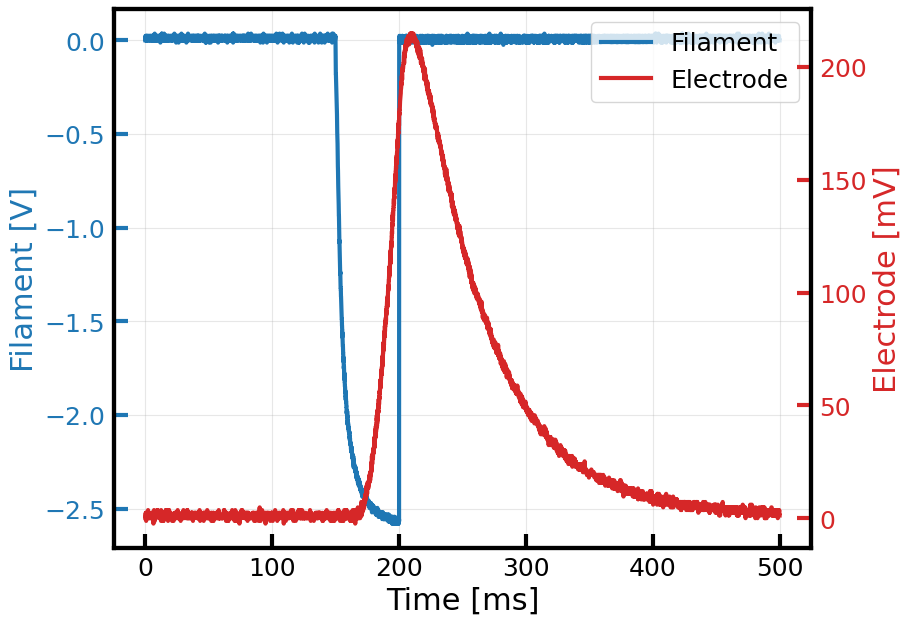

In [127]:
arr  = np.array(data_matrix)
msk  = np.abs(arr[:,2] - stats.mode(arr[:,2])[0]) > 1e-6
data = arr[msk]

columns = ['Sourced [V]', 'Time [s]', 'Filament [V]', 'Electrode [V]']
df = pd.DataFrame(data, columns=columns)

target_amp = 3.0  # desired amplitude

# If Sourced [V] was stored as round(amp, 3), you can match exactly:
sub = df[df['Sourced [V]'] == round(target_amp, 3)]
# Extract series
times = sub['Time [s]'].to_numpy()
elect = sub['Electrode [V]'].to_numpy()
filam = sub['Filament [V]'].to_numpy()


# Plotting parameters
line_w = 3
font_t = 18
font_l = 22
line_l = 10

fig, ax1 = plt.subplots(figsize=(9, 7))

# Choose distinct colors
f_color = '#1f77b4'  # blue
e_color = '#d62728'  # red

# Left axis: Filament
ln1, = ax1.plot(times*1e3, filam - filam[0], color=f_color, lw=line_w, 
                label='Filament')
ax1.set_xlabel('Time [ms]', fontsize=font_l)
ax1.set_ylabel('Filament [V]', color=f_color, fontsize=font_l)
ax1.tick_params(axis='y', labelcolor=f_color)

# Right axis: Electrode
ax2 = ax1.twinx()
ln2, = ax2.plot(times*1e3, elect*1e3 - elect[0]*1e3, color=e_color, lw=line_w, 
                label='Electrode')
ax2.set_ylabel('Electrode [mV]', color=e_color, fontsize=font_l)
ax2.tick_params(axis='y', labelcolor=e_color)

# One combined legend
lines = [ln1, ln2]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc=1, fontsize=font_t)

# Optional: grid on the main axis
ax1.grid(True, alpha=0.3)

# Optional: style x-axis ticks
ax1.tick_params(axis='x', length=line_l, width=line_w, labelsize=font_t,
                 direction='in', pad=6, colors='black')
ax1.tick_params(axis='y', length=line_l, width=line_w, labelsize=font_t,
                 direction='in', pad=6, colors=f_color)
ax2.tick_params(axis='y', length=line_l, width=line_w, labelsize=font_t,
                 direction='in', pad=6, colors=e_color)


# Spine formatting
for spine in ax1.spines.values():
    spine.set_linewidth(line_w)
for spine in ax2.spines.values():
    spine.set_linewidth(line_w)
ax2.spines['left'].set_color('black')
ax2.spines['right'].set_color('black')


In [118]:
saver = DataSaver(create_path_filename('J_filament_scope'))

'''metadata = {
    'Cell Port': 'J8',
    'Device': "Camille's",
    'Temperature': '500 mK',
    'instrument': 'Keysight 33500B',
    'filament_voltage': amp,
    'filament_offset': -amp / 2,
    'waveform': 'square',
    'filament_frequency': 1,
    'duty_cycle': 5,
    'preamplifier': 'true',
    'amp_filter_type': 'low-pass',
    'amp_filter_freq': '3 Hz',
    'amp_filter_attn': '6 dB',
    'amp_sensitivity': '100 nA/V',
    'amp_bias': '0 V',
    'bias_channel': 'J5',

}'''

metadata = {
    'Temperature': 'Room Temp',
    'instrument': 'Keysight 33500B',
    'filament_voltage': amp,
    'filament_offset': -amp / 2,
    'waveform': 'square',
    'filament_frequency': 1,
    'duty_cycle': 5,
}

def patched_build_schema(columns, scheme=None):
    return {
        'table_measurements': {
            'params': columns,
            'types': ['REAL' for _ in columns]
        },
        'metadata': {
            'params': ['category', 'key', 'value'],
            'types': ['TEXT', 'TEXT', 'TEXT']
        },
        'table_sweep': {'params': [], 'types': []},
        'table_step': {'params': [], 'types': []}
    }
saver._build_schema = patched_build_schema


saver.save_to_db(
    exp_name="RT_Filament_Scope",
    columns=columns,
    sweep_data=data,
    metadata=metadata
)

Data saved to data\2026-01-16\2026-01-16_RT_Filament_Scope.db


'data\\2026-01-16\\2026-01-16_RT_Filament_Scope.db'

## **Pressure Gauge Collection**

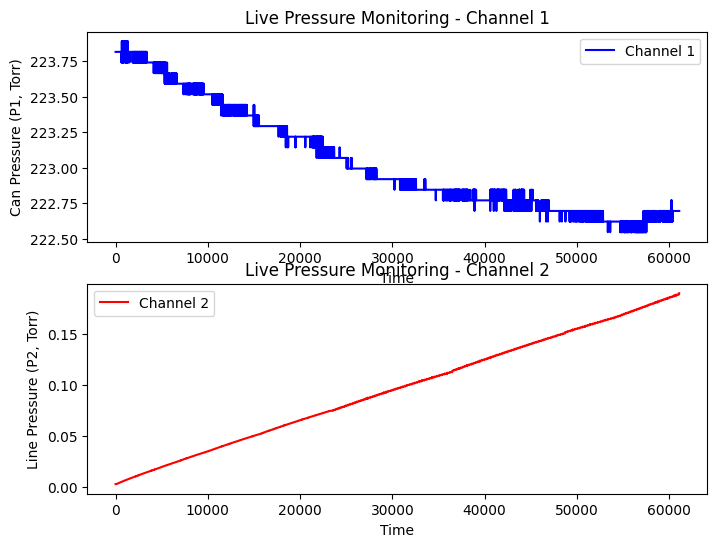

Final save...
Overwrite enabled: using 2025-11-24_pressure_line_recording.db
Data saved to data\2025-11-24\2025-11-24_pressure_line_recording.db
Recording stopped.


In [ ]:

# Experiment details
exp_name = "pressure_line_recording"
columns = ["ElapsedSeconds", "TimestampStr", "Pressure1", "Pressure2"]

# Initialize DataSaver
datasaver = DataSaver()

# Storage
data = []
stop_flag = False
start_time = time.time()
columns = ["ElapsedSeconds", "TimestampStr", "Pressure1", "Pressure2"]


# Function to wait for stop signal
def wait_for_stop():
    input("Press Enter to stop...\n")
    global stop_flag
    stop_flag = True

threading.Thread(target=wait_for_stop).start()

# Live plotting setup
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
line1, = ax1.plot([], [], 'b-', label="Channel 1")
line2, = ax2.plot([], [], 'r-', label="Channel 2")

ax1.set_xlabel("Time")
ax1.set_ylabel("Can Pressure (P1, Torr)")
ax1.set_title("Live Pressure Monitoring - Channel 1")
ax1.legend()

ax2.set_xlabel("Time")
ax2.set_ylabel("Line Pressure (P2, Torr)")
ax2.set_title("Live Pressure Monitoring - Channel 2")
ax2.legend()
plt.show()

last_save_time = time.time()
save_interval = 5 * 60  # 15 minutes in seconds

print("Recording started...")

while not stop_flag:
    # Measure pressures from both channels
    pressure1 = dpg.measure('Pressure1')
    pressure2 = dpg.measure('Pressure2')
    timestamp = time.time()
    elapsed = round(timestamp - start_time, 2)
    timestamp_str = pd.to_datetime(timestamp, unit='s').strftime('%Y-%m-%d %H:%M:%S')

    # Append data
    data.append((timestamp, timestamp_str, pressure1, pressure2))

    # Wait to lower point density
    time.sleep(5)

    # Update plots
    times = [round(d[0] - start_time, 2) for d in data]
    pressures1 = [d[2] for d in data]
    pressures2 = [d[3] for d in data]

    line1.set_xdata(times)
    line1.set_ydata(pressures1)
    ax1.relim()
    ax1.autoscale_view()

    line2.set_xdata(times)
    line2.set_ydata(pressures2)
    ax2.relim()
    ax2.autoscale_view()

    clear_output(wait=True)
    display(fig)

    # Periodic save to DB
    if time.time() - last_save_time >= save_interval:
        print("Saving data to database...")
        
        sweep_data = [
            (
                round(t - start_time, 2),  # ElapsedSeconds
                pd.to_datetime(t, unit='s').strftime('%Y-%m-%d %H:%M:%S'),
                float(p1),
                float(p2)
            )
            for t, p1, p2 in [(d[0], d[2], d[3]) for d in data]
        ]

        datasaver.save_to_db(exp_name, columns, sweep_data, scheme='dpg',
                              overwrite=True)
        last_save_time = time.time()

    time.sleep(1)  # Adjust sampling rate as needed

# Final save after stop
print("Final save...")
sweep_data = [
    (
        round(t - start_time, 2),  # ElapsedSeconds
        pd.to_datetime(t, unit='s').strftime('%Y-%m-%d %H:%M:%S'), 
        float(p1),
        float(p2)
    )
    for t, p1, p2 in [(d[0], d[2], d[3]) for d in data]
]
datasaver.save_to_db(exp_name, columns, sweep_data, scheme='dpg',
                     overwrite=True)
print("Recording stopped.")



## **Filling Curve**

In [5]:
# VNA configuration
expr.freq_range = (5.3*GHz, 5.5*GHz)
vna.set_power(10)
vna.set_ifbw(200)
pts = 501
vna.set_sweep_points(pts)
vna.set_measure_def('meas', 'S21', 1)
vna.set_averages(4)
vna.set_average_state(True)
vna.set_output('ON')

# Initialize DataSaver
datasaver = DataSaver()

# 
experiment_name = "VNA_QuickScan_2"

In [ ]:
logger = VNALogger(vna, dpg, datasaver,
                   exp_name=experiment_name,
                   columns=["ElapsedSeconds", "TimestampStr", 
                            "Pressure1", "Pressure2",
                            "Frequency", "VNA Real", "VNA Imag"])

threading.Thread(target=logger.vna_log,
                 kwargs={      'wait_time': 10,
                         'record_pressure': True},
                 daemon=True).start()

Recording started...


Final save...
Avoiding overwrite, new filename: 2026-02-03_VNA_QuickScan_-4.db
Data saved to data\2026-02-03\2026-02-03_VNA_QuickScan_-4.db
Recording stopped.


In [15]:
vna.set_output('OFF')

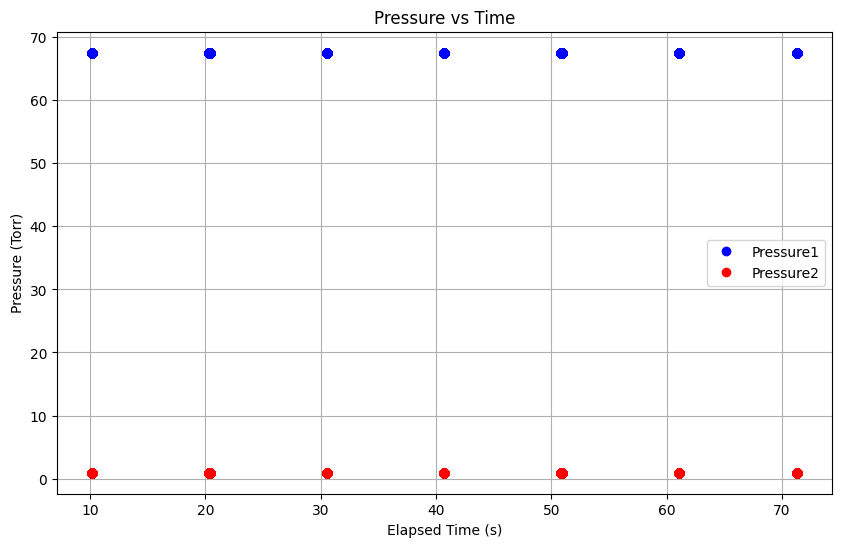

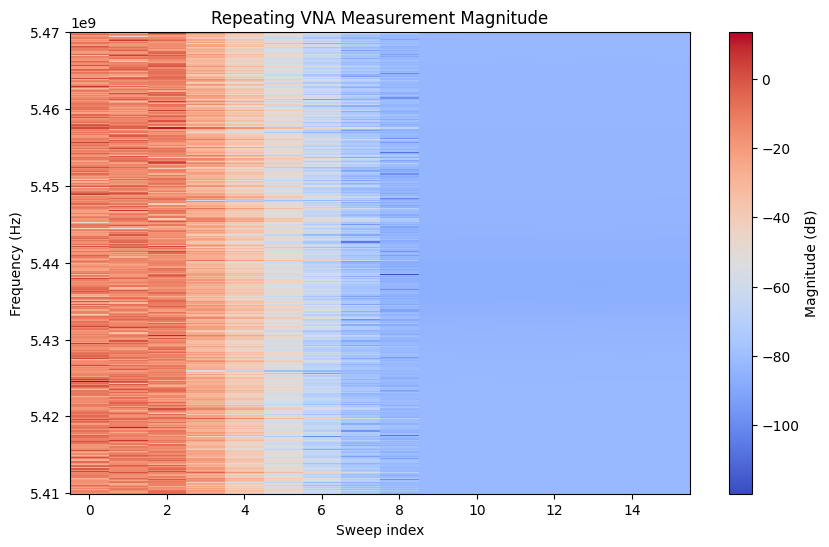

In [25]:
# Pull file path after logging
db_path = logger.filepath
# Pull data back from the database
records = datasaver.load_table_meas(db_path)

# Convert to DataFrame
df = pd.DataFrame(records, columns=[
    "ElapsedSeconds", "TimestampStr", "Pressure1", "Pressure2",
    "Frequency", "VNA Real", "VNA Imag"
])

# Plot pressures vs elapsed time
plt.figure(figsize=(10, 6))
plt.plot(df["ElapsedSeconds"], df["Pressure1"], 'o', label="Pressure1", color='blue')
plt.plot(df["ElapsedSeconds"], df["Pressure2"], 'o', label="Pressure2", color='red')
plt.xlabel("Elapsed Time (s)")
plt.ylabel("Pressure (Torr)")
plt.title("Pressure vs Time")
plt.legend()
plt.grid(True)
plt.show()

# Ensure numeric conversion
df["VNA Real"] = pd.to_numeric(df["VNA Real"], errors="coerce")
df["VNA Imag"] = pd.to_numeric(df["VNA Imag"], errors="coerce")
df["Frequency"] = pd.to_numeric(df["Frequency"], errors="coerce")

# Compute magnitude in dB
df["Magnitude_dB"] = 20 * np.log10(np.sqrt(df["VNA Real"].astype(float)**2 +
                                           df["VNA Imag"].astype(float)**2))

# Number of points per sweep
points_per_sweep = pts
num_sweeps = len(df) // points_per_sweep

# Reshape magnitude into 2D array: [sweep, frequency]
magnitude_matrix = df["Magnitude_dB"].values.reshape(num_sweeps, points_per_sweep)

# Frequency axis (same for each sweep, take first sweep slice)
freq_axis = df["Frequency"].values[:points_per_sweep].astype(float)

# Sweep axis
sweep_axis = np.arange(num_sweeps)

# Create meshgrid for pcolormesh
X, Y = np.meshgrid(sweep_axis, freq_axis)

plt.figure(figsize=(10, 6))
pcm = plt.pcolormesh(X, Y, magnitude_matrix.T, cmap="coolwarm", shading="auto",
#                    vmax=-80, vmin=-90
                    )

plt.xlabel("Sweep index")
plt.ylabel("Frequency (Hz)")
plt.title("Repeating VNA Measurement Magnitude")
plt.colorbar(pcm, label="Magnitude (dB)");